In [1]:
import torch
import torch.nn as nn
import yaml
import sys

In [2]:
with open('./model_config.yml', 'r') as file:
    config = yaml.safe_load(file)
    decoder_config = config["Decoder"]
    prior_config = config["Prior"]
    clip_config = config["CLIP"]

In [3]:
sys.path.insert(0, 'clip')
from clip.model import CLIP

sys.path.insert(0, 'dalle2')
from prior import Prior
from decoder import UNet, Decoder
from diffusion import Diffusion
from dalle2_model import DALLE2

In [4]:
decoder_path = "./models/decoder3_cosine.pth"
prior_path = "./models/prior3_cosine.pth"
clip_path = "./models/clip3.pth"


decoder_state = torch.load(decoder_path)
prior_state = torch.load(prior_path)
clip_state = torch.load(clip_path)

decoder_config = decoder_state["config"]["Decoder"]
prior_config = prior_state["config"]["Prior"]
clip_config = clip_state["config"]["CLIP"]

In [5]:
# Define hyperparameters
T = decoder_config["diffusion_timesteps"]
BATCH_SIZE = decoder_config["batch_size"]
IMG_SIZE = config["img_size"]
EPOCHS = decoder_config["epochs"]
LR = decoder_config["lr"]
GRAD_CLIP = decoder_config["grad_clip"]
NULL_TEXT_EMB_RATE = decoder_config["null_text_emb_rate"]
NULL_CLIP_EMB_RATE = decoder_config["null_clip_emb_rate"]
GUIDANCE_SCALE = decoder_config["guidance_scale"]

# CLIP embedding dimension
CLIP_EMB_DIM = config["CLIP"]["embed_dim"]

# UNet
DOWN_CHANNELS = decoder_config["down_channels"]
TIME_EMB_DIM = decoder_config["time_emb_dim"]

# UNet Transformer
N_VOCAB = decoder_config["n_vocab"]
CONTEXT_LENGTH = decoder_config["context_length"]
TRANSFORMER_WIDTH = decoder_config["transformer_width"]
TRANSFORMER_LAYERS = decoder_config["transformer_layers"]
TRANSFORMER_HEADS = decoder_config["transformer_heads"]

# UNet attention block
QKV_HEADS = decoder_config["qkv_heads"]


# Create diffusion
decoder_diffusion = Diffusion(T, schedule=decoder_config["noise_schedule"])
# decoder_diffusion = Diffusion(T, schedule="linear")

# Create UNet
unet = UNet(
    down_channels=DOWN_CHANNELS,
    time_emb_dim=TIME_EMB_DIM,
    n_vocab=N_VOCAB,
    context_length=CONTEXT_LENGTH,
    transformer_width=TRANSFORMER_WIDTH,
    transformer_layers=TRANSFORMER_LAYERS,
    transformer_heads=TRANSFORMER_HEADS,
    qkv_heads=QKV_HEADS,
    clip_emb_dim=CLIP_EMB_DIM
)
# state = torch.load(decoder_config["model_path"])

# Create decoder
decoder = Decoder(unet, num_timesteps=T)
decoder.load_state_dict(decoder_state["model"])

<All keys matched successfully>

In [6]:
decoder_config

{'diffusion_timesteps': 300,
 'noise_schedule': 'cosine',
 'batch_size': 64,
 'epochs': 1500,
 'lr': 0.001,
 'grad_clip': 1,
 'null_text_emb_rate': 0.2,
 'null_clip_emb_rate': 0.2,
 'guidance_scale': 3,
 'down_channels': [64, 128, 256],
 'time_emb_dim': 32,
 'n_vocab': 49408,
 'context_length': 33,
 'transformer_width': 64,
 'transformer_layers': 6,
 'transformer_heads': 8,
 'qkv_heads': 8,
 'normalize_clip_embeddings': True,
 'model_path': './models/decoder3.pth'}

In [7]:
T = prior_config["diffusion_timesteps"]
BATCH_SIZE = prior_config["batch_size"]
IMG_SIZE = config["img_size"]
EPOCHS = prior_config["epochs"]
LR = prior_config["lr"]

prior_diffusion = Diffusion(T, schedule=prior_config["noise_schedule"])

# Create Prior
# prior = Prior(
#     dim=config["CLIP"]["embed_dim"],
#     num_timesteps=T,
#     max_text_len=CONTEXT_LENGTH,
#     depth=prior_config["depth"],
#     dim_head=prior_config["dim_per_head"],
#     heads=prior_config["heads"],
#     ff_mult=prior_config["ff_mult"],
# )
prior = Prior(
    clip_emb_dim=clip_config["embed_dim"],
    T=T,
    clip_context_len=clip_config["context_length"],
    clip_token_dim=clip_config["transformer_width"],
    xf_layers=prior_config["xf_layers"],
    # dim_head=prior_config["dim_per_head"],
    xf_heads=prior_config["xf_heads"],
    # vocab_size=clip_config["vocab_size"],
    # ff_mult=prior_config["ff_mult"],
)
prior.load_state_dict(prior_state["model"])
# prior.load_state_dict(torch.load(prior_config["model_path"]))


<All keys matched successfully>

In [8]:
clip = CLIP(
    embed_dim=clip_config["embed_dim"],
    image_resolution=IMG_SIZE,
    vision_layers=clip_config["vision_layers"],
    vision_width=clip_config["vision_width"],
    vision_patch_size=clip_config["vision_patch_size"],
    context_length=clip_config["context_length"],
    vocab_size=clip_config["vocab_size"],
    transformer_width=clip_config["transformer_width"],
    transformer_heads=clip_config["transformer_heads"],
    transformer_layers=clip_config["transformer_layers"]
)
# state = torch.load(clip_config["model_path"])

clip.load_state_dict(clip_state["model"])

<All keys matched successfully>

In [9]:
dalle2 = DALLE2(clip, prior, decoder)
dalle2.val_mode()


In [10]:
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt

IMG_DIM = (3, IMG_SIZE, IMG_SIZE)
reverse_transforms = transforms.Compose([
    transforms.Lambda(lambda t: (t + 1) / 2),
    transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
    transforms.Lambda(lambda t: t * 255.),
    transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
    transforms.ToPILImage(),
])
def show_tensor_image(image):
    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

dalle2 = dalle2.to(device=device)

cuda


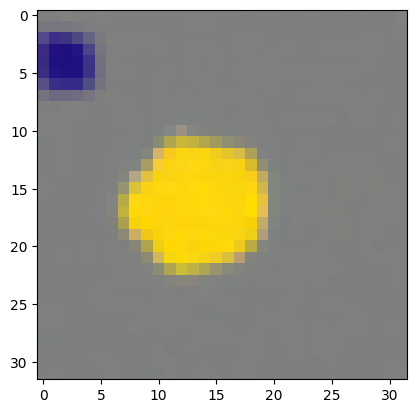

In [73]:

image = dalle2((3, IMG_SIZE, IMG_SIZE), "a small black square and a large gold pentagon", prior_diffusion, decoder_diffusion, cf_guidance_scale=2)
show_tensor_image(image.detach().cpu())

In [21]:
sys.path.insert(0, 'dataset')
from dataset import load_data
from torch.utils.data import DataLoader

train_data, test_data = load_data(root_dir="./data3", img_size=IMG_SIZE)
dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

Dataset size: 20000
Dataset size: 2000


In [71]:
import pandas as pd
pd.unique(train_data.captions).shape

(10418,)

In [17]:
idx = 3
image = img[None, idx]
text = txt[idx]

print(text)

a black rectangle


In [48]:
sys.path.insert(0, 'nn_components')
from tokenizer import tokenize

text_tokens = tokenize(text, context_length=dalle2.clip.context_length)
text_tokens = text_tokens.to(device=dalle2.device)
text_embedding = dalle2.clip.encode_text(text_tokens, normalize=True)
image_embedding = dalle2.prior.sample(prior_diffusion, text_embedding, text_encodings=text_tokens)

In [49]:
image_embedding_truth = dalle2.clip.encode_image(image.to(device=dalle2.device), normalize=True)

print(image_embedding)
print(image_embedding_truth)

tensor([[ 0.4166, -0.0312,  0.3619,  0.0209, -0.4754,  0.5349]],
       device='cuda:0')
tensor([[ 0.2169, -0.0241,  0.4038, -0.3160, -0.6890,  0.4634]],
       device='cuda:0')


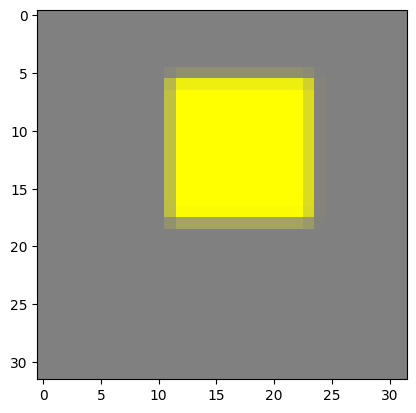

In [50]:
show_tensor_image(image)

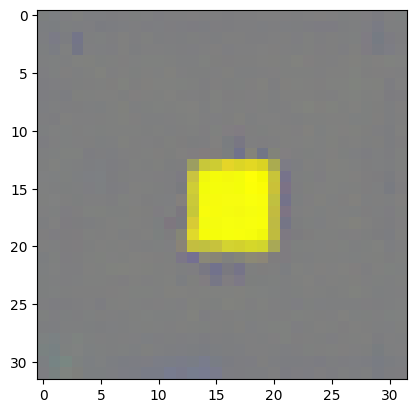

In [51]:
decoder = decoder.train()
img_pred = decoder.sample_one(IMG_DIM, text_tokens, clip_emb=image_embedding,diffusion=decoder_diffusion,cf_guidance_scale=2)
show_tensor_image(img_pred.detach().cpu())

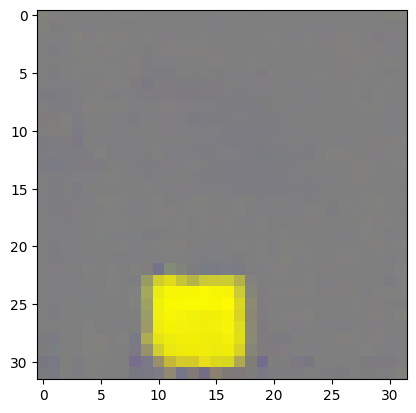

In [52]:
img_pred = decoder.sample_one(IMG_DIM, text_tokens, clip_emb=image_embedding_truth,diffusion=decoder_diffusion,cf_guidance_scale=2)
show_tensor_image(img_pred.detach().cpu())

In [31]:
@torch.no_grad()
def sample_plot_image(decoder: Decoder, tokens, clip_emb, diffusion: Diffusion, guidance_scale=GUIDANCE_SCALE, **kwargs):
    # model.eval()
    assert tokens.shape == (1, CONTEXT_LENGTH)
    # Sample noise
    img = torch.randn((1, 3, IMG_SIZE, IMG_SIZE), device=device)
    fig = plt.figure(figsize=(15,6))
    plt.axis('off')

    num_images = 10
    stepsize = int(T/num_images)

    title = kwargs["caption"]
    assert clip_emb.shape == (1, CLIP_EMB_DIM)

    plt.title(title)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = decoder.sample_timestep(img, t, tokens, clip_emb, diffusion, cf_guidance_scale=guidance_scale)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            fig.add_subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()

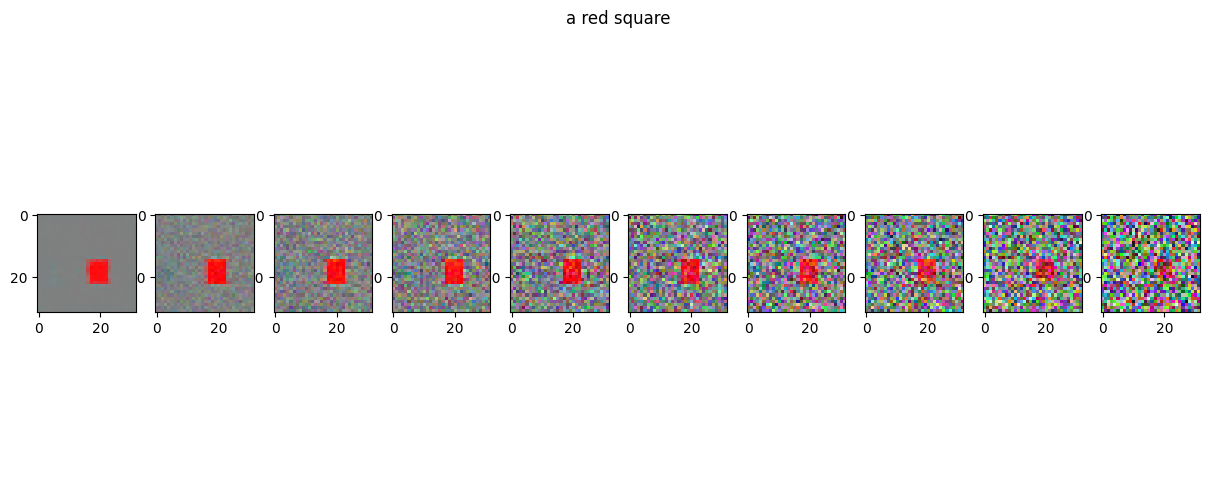

In [38]:
sample_plot_image(decoder, text_tokens, image_embedding_truth, decoder_diffusion, guidance_scale=2, caption=text)

In [16]:
from sklearn.neighbors import NearestNeighbors

def knn(x, xs, k=5, metric="euclidean"):
    nbrs = NearestNeighbors(n_neighbors=k, metric=metric).fit(xs)
    distances, indices = nbrs.kneighbors(x)
    return distances, indices

In [17]:
import tqdm

image_embeddings = []
with torch.no_grad():
    for step, (img, txt) in enumerate(dataloader):
        img = img.to(device=dalle2.device)
        img_emb = dalle2.clip.encode_image(img, normalize=True)
        image_embeddings.append(img_emb.detach().cpu().numpy())

In [18]:
from functools import reduce

image_embeddings = reduce(lambda x, y: np.concatenate((x, y)), image_embeddings)

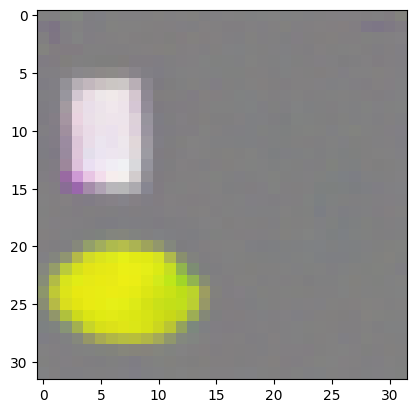

In [117]:
image = dalle2((3, IMG_SIZE, IMG_SIZE), "a white rectangle and a yellow ellipse", prior_diffusion, decoder_diffusion, cf_guidance_scale=2)
show_tensor_image(image.detach().cpu())

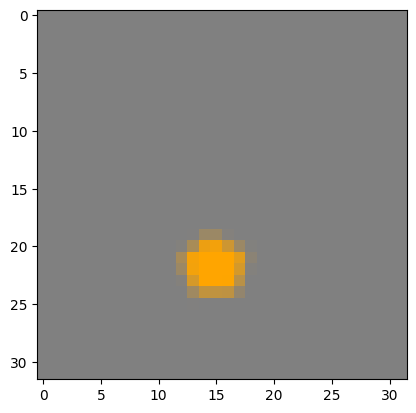

In [110]:

image = train_data[88][0][None, :, :, :]
show_tensor_image(image)

11567


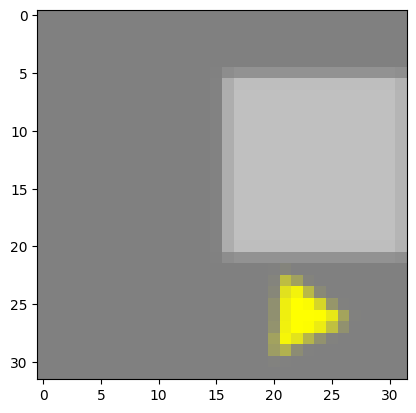

1424


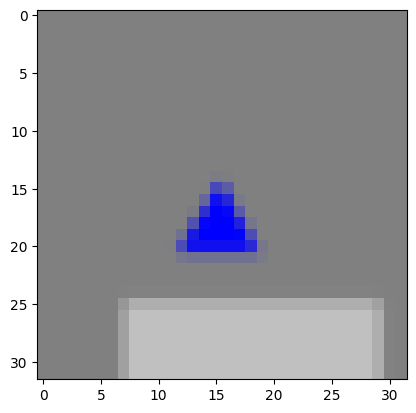

11575


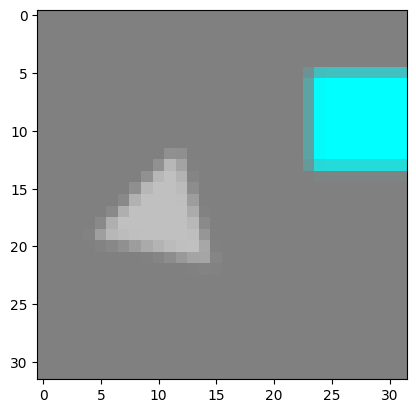

11770


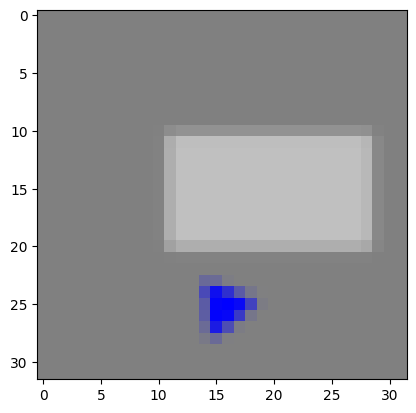

1713


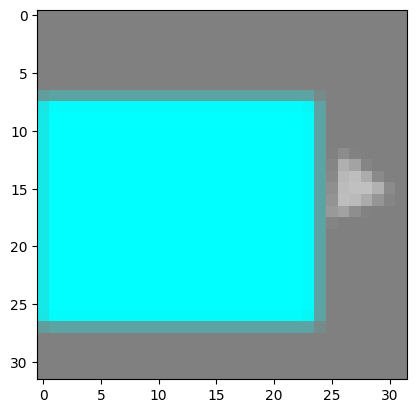

In [118]:
image_embedding = dalle2.clip.encode_image(image.to(device=dalle2.device), normalize=True)
image_embedding = image_embedding.detach().cpu().numpy()
_, indices = knn(image_embedding, image_embeddings, k=5, metric="euclidean")
for i in indices[0]:
    print(i)
    show_tensor_image(train_data[i][0])
    plt.show()

In [119]:
print(image_embedding)
# print(image_embeddings[indices[0][0]])
print(image_embeddings[11567])

[[-2.21415400e-03  3.84702869e-02  1.91590209e-02 -1.29403025e-01
   2.08721142e-02  7.84545317e-02  7.22459331e-02 -4.36300114e-02
  -2.53236550e-03  4.37679477e-02 -8.58548004e-03 -2.54510995e-02
   1.46583300e-02  8.16021040e-02  1.23583734e-01 -6.04330860e-02
   6.88675344e-02  3.49217393e-02  4.34978046e-02 -4.26559635e-02
   1.41582955e-02  2.58016214e-03  4.37681116e-02  8.51965621e-02
   5.54014817e-02 -3.59445028e-02 -4.96664084e-02  3.71118039e-02
  -6.33530766e-02  3.30435559e-02  2.77439877e-02  2.45364636e-01
   5.83640598e-02  1.08500049e-01 -7.67985359e-02 -6.57600388e-02
  -9.73851010e-02 -1.92199796e-02 -2.33550090e-02  9.50873569e-02
   3.50309275e-02  1.98424328e-02 -2.22428627e-02  1.29935136e-02
   3.81428674e-02 -6.29486144e-02  3.82073224e-02  2.74566971e-02
  -7.07880966e-03 -7.09944442e-02 -4.12776396e-02 -3.06055807e-02
   4.16591987e-02  3.35150063e-02 -1.35172000e-02  1.35312220e-02
   4.79028560e-02 -2.73467917e-02  6.91024438e-02  2.87091499e-03
   3.79242

In [48]:
def cosine_similarity(x, y):
    return np.dot(x, y)/(np.linalg.norm(x)*np.linalg.norm(y))

In [120]:
print(cosine_similarity(image_embedding, image_embeddings[11567]))

[0.83047163]


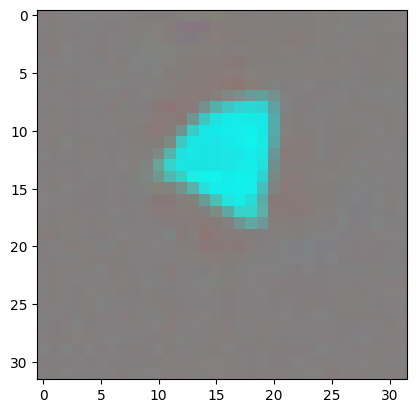

In [61]:
image = dalle2((3, IMG_SIZE, IMG_SIZE), "a large cyan triangle", prior_diffusion, decoder_diffusion, cf_guidance_scale=2)
show_tensor_image(image.detach().cpu())

9779


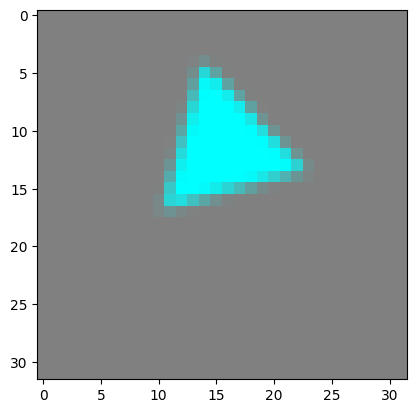

13819


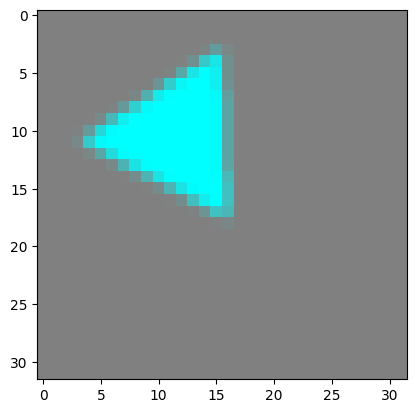

2405


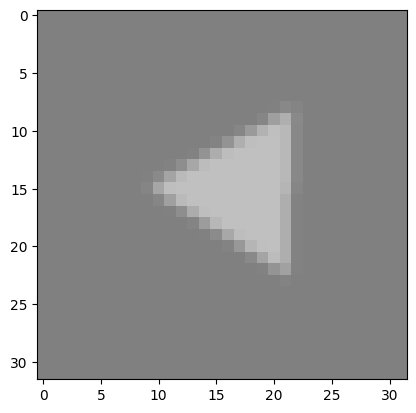

7189


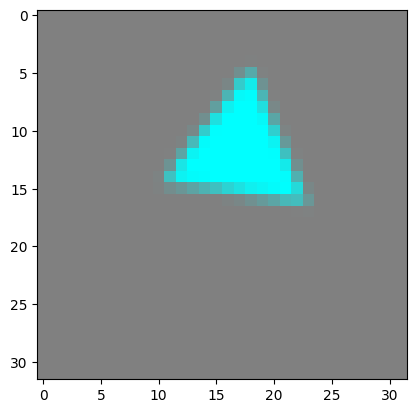

8699


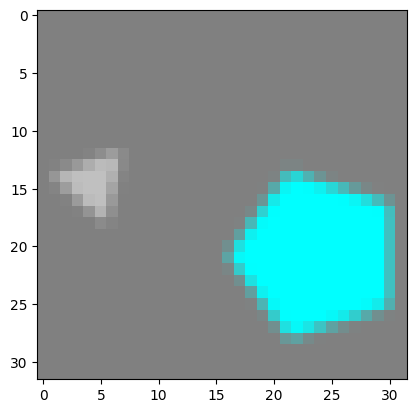

In [62]:
image_embedding = dalle2.clip.encode_image(image.to(device=dalle2.device), normalize=True)
image_embedding = image_embedding.detach().cpu().numpy()
_, indices = knn(image_embedding, image_embeddings, k=5, metric="euclidean")
for i in indices[0]:
    print(i)
    show_tensor_image(train_data[i][0])
    plt.show()

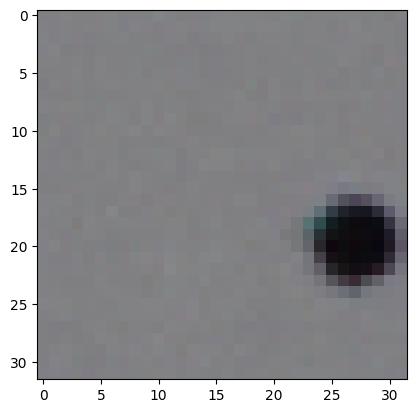

In [121]:
image = dalle2((3, IMG_SIZE, IMG_SIZE), "a circle", prior_diffusion, decoder_diffusion, cf_guidance_scale=2)
show_tensor_image(image.detach().cpu())

In [ ]:
def generate_images(n, cf_guidance_scale, all_captions):
    images = []
    captions = []
    for i in range(n):
        caption = np.random.choice(all_captions)
        captions.append(caption)
        image = dalle2((3, IMG_SIZE, IMG_SIZE), caption, prior_diffusion, decoder_diffusion, cf_guidance_scale=cf_guidance_scale)
        images.append(image.detach().cpu())
        if i % 10 == 0:
            print(i)

In [74]:
images = []
captions = []
all_captions = pd.unique(train_data.captions)
for i in range(1000):
    caption = np.random.choice(all_captions)
    captions.append(caption)
    image = dalle2((3, IMG_SIZE, IMG_SIZE), caption, prior_diffusion, decoder_diffusion, cf_guidance_scale=2)
    images.append(image.detach().cpu())
    if i % 10 == 0:
        print(i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [83]:
for i in range(len(images)):
    filename = f"{i}.png"
    image = reverse_transforms(images[i].squeeze(0))
    image.save(f"evaluations/v3/cf2/normal/images/{filename}.png")

In [85]:
cs = pd.DataFrame({"caption": captions})
cs.to_csv("evaluations/v3/cf2/normal/captions.csv")

In [87]:
import torch_fidelity

metrics_dict = torch_fidelity.calculate_metrics(
    input1="data3/train/images", 
    input2="data3/train/images", 
    cuda=True, 
    isc=True, 
    fid=True, 
    kid=True, 
    prc=True, 
    verbose=False,
)

/vol/bitbucket/hl3919/miniconda3/envs/fyp/lib/python3.8/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)


In [88]:
metrics_dict

{'inception_score_mean': 2.3622372398183273,
 'inception_score_std': 0.03377852815792885,
 'frechet_inception_distance': 2.0179413695586845e-12,
 'kernel_inception_distance_mean': -4.624631381381583e-05,
 'kernel_inception_distance_std': 9.018269641806845e-05}

In [26]:
data_transforms = [
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.PILToTensor()
    # transforms.ToTensor(), # Scales data into [0,1]
    # transforms.RandomRotation(degrees=180, fill=128),
    # transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
]
data_transform = transforms.Compose(data_transforms)

train_data.image_only(True)
train_data.transform = data_transform

test_data.image_only(True)
test_data.transform = data_transform

In [40]:
for i in range(len(train_data)):
    image = transforms.ToPILImage()(train_data[i])
    image.save(f"evaluations/v3/reference/normal/images/train_{i}.png")
    

In [ ]:
import torch_fidelity

In [45]:
torch_fidelity.calculate_metrics(
    input1="evaluations/v3/cf1.5/images", 
    input2="evaluations/v3/reference/normal/images", 
    cuda=True, 
    # isc=True, 
    fid=True, 
    kid=True, 
    prc=True, 
    verbose=True,
)

Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "evaluations/v3/cf1.5/images" with extensions png,jpg,jpeg
Found 3401 samples
Processing samples                                                           
Extracting features from input2
Looking for samples non-recursivelty in "evaluations/v3/reference/normal/images" with extensions png,jpg,jpeg
Found 20000 samples
Processing samples                                                             
Frechet Inception Distance: 61.078488613778404
Kernel Inception Distance: 0.05864583952952951 ± 0.0017571379732438913           
Creating feature extractor "vgg16" with features ['fc2_relu']
Extracting features from input1
Looking for samples non-recursivelty in "evaluations/v3/cf1.5/images" with extensions png,jpg,jpeg
Found 3401 samples
Processing samples                                                           
Extracting features from input2
Looking

In [46]:
metrics_dict

{'frechet_inception_distance': 61.078488613778404,
 'kernel_inception_distance_mean': 0.05864583952952951,
 'kernel_inception_distance_std': 0.0017571379732438913,
 'precision': 0.8019499778747559,
 'recall': 0.21287856996059418,
 'f_score': 0.33644690984315145}

In [44]:
torch_fidelity.calculate_metrics(
    input1="evaluations/v3/cf2/normal_cosine/images", 
    input2="evaluations/v3/reference/normal/images", 
    cuda=True, 
    # isc=True, 
    fid=True, 
    kid=True, 
    prc=True, 
    verbose=True,
)

Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "evaluations/v3/cf2/normal_cosine/images" with extensions png,jpg,jpeg
Found 3401 samples
Processing samples                                                           
Extracting features from input2
Looking for samples non-recursivelty in "evaluations/v3/reference/normal/images" with extensions png,jpg,jpeg
Found 20000 samples
Processing samples                                                             
Frechet Inception Distance: 60.02799004016376
Kernel Inception Distance: 0.05711728177927927 ± 0.001811534677474119            
Creating feature extractor "vgg16" with features ['fc2_relu']
Extracting features from input1
Looking for samples non-recursivelty in "evaluations/v3/cf2/normal_cosine/images" with extensions png,jpg,jpeg
Found 3401 samples
Processing samples                                                           
Extracting featu

In [ ]:
cf_scales = [1, 1.5, 2, 2.5, 3]
fids = [0, 61.078488613778404, 60.02799004016376, 0, 0]
kids = [0, 0.05864583952952951, 0.05711728177927927, 0, 0]
kid_errors = [0, 0.0017571379732438913, 0.001811534677474119, 0, 0]
precisions = [0, 0.8019499778747559, 0.810949981212616, 0, 0]
recalls = [0, 0.21287856996059418, 0.22081740200519562, 0, 0]
f1s = [0, 0.33644690984315145, 0.34711674534438935, 0, 0]

In [24]:
# train_data1, _ = load_data(root_dir="./data3", img_size=IMG_SIZE)

# train_data1.image_only(True)
# data_transforms = [
#     # transforms.Resize((IMG_SIZE, IMG_SIZE)),
#     transforms.RandomHorizontalFlip(),
#     transforms.PILToTensor()
#     # transforms.ToTensor(), # Scales data into [0,1]
#     # transforms.RandomRotation(degrees=180, fill=128),
#     # transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
# ]
# data_transform = transforms.Compose(data_transforms)

# train_data1.transform = data_transform

Dataset size: 20000
Dataset size: 2000


In [33]:
import torch_fidelity
metrics_dict = torch_fidelity.calculate_metrics(
    input1="evaluations/v3/cf1.5/images", 
    input2="evaluations/v3/cf2/normal_cosine/images", 
    cuda=True, 
    # isc=True, 
    fid=True, 
    kid=True, 
    prc=True, 
    verbose=True,
)

Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "evaluations/v3/cf1.5/images" with extensions png,jpg,jpeg
Found 3000 samples
Processing samples                                                           
Extracting features from input2
Looking for samples non-recursivelty in "evaluations/v3/cf2/normal_cosine/images" with extensions png,jpg,jpeg
Found 3000 samples
Processing samples                                                           
Frechet Inception Distance: 6.613745607710172
Kernel Inception Distance: 0.0005539072447447646 ± 0.0002235912029856476         
Creating feature extractor "vgg16" with features ['fc2_relu']
Extracting features from input1
Looking for samples non-recursivelty in "evaluations/v3/cf1.5/images" with extensions png,jpg,jpeg
Found 3000 samples
Processing samples                                                           
Extracting features from input2
Looking fo

In [ ]:
all_captions = pd.unique(train_data.captions)



# CLIP interpolation

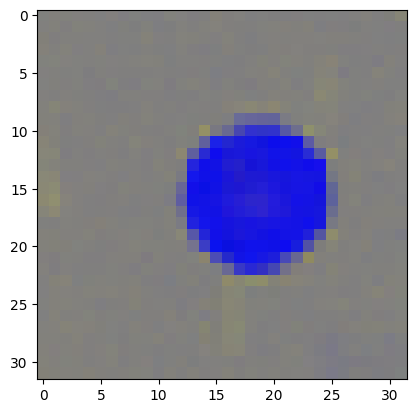

In [130]:
image = dalle2((3, IMG_SIZE, IMG_SIZE), "a large blue circle", prior_diffusion, decoder_diffusion, cf_guidance_scale=2)
show_tensor_image(image.detach().cpu())